In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from evaluation_util import sensitivity, load_and_prepare_usgs, calculate_diff, prepare_data_for_plotting, calculate_ensemble_weights_and_flows
warnings.filterwarnings("ignore")

In [2]:
number = 11
multi_models = [f'short_range_{i}' for i in range(1, number+1)]

In [ ]:
with open('bridge_gua.pkl', 'rb') as file:
    bridge_gua = pickle.load(file)

with open('raw_data.pkl', 'rb') as file:
    raw = pickle.load(file)

with open('open_data.pkl', 'rb') as file:
    all_outputs_open = pickle.load(file)

all_outputs_da = {}
for model_name in multi_models:
    with open(f'{model_name}_outputs.pkl', 'rb') as file:
        model_outputs = pickle.load(file)
    all_outputs_da[model_name] = model_outputs

In [5]:
filtered_bridge = {key: value for key, value in bridge_gua.items() if value['overflow']}

In [6]:
GAUGES_USGS = {
    # san antonio
    "10840818":'USGS-08178050',
    "10840824":'USGS-08178500',
    "10840502":'USGS-08178565',
    "10840230":'USGS-08178593',
    "10840232":'USGS-08178700',
    "10840488":'USGS-08178800',
    "10834470":'USGS-0817887350', 
    "10833740":'USGS-08178880',
    "10834916":'USGS-08178980', 
    "10835018":'USGS-08180586', 
    "10836382":'USGS-08180640', 
    "10835982":'USGS-08180700',
    "10836104":'USGS-08180800', 
    "10835030":'USGS-08181400', 
    "10836388":'USGS-08181480',
    "10836092":'USGS-08181500', 
    "10840558":'USGS-08181725',
    "10840572":'USGS-08181800',
    "3836053":'USGS-08183200',
    "3838221":'USGS-08183500', 
    "7850579":'USGS-08183900', 
    "7850611":'USGS-08183978', 
    "7850687":'USGS-08185065', 
    "7851629":'USGS-08185100', 
    "7851771":'USGS-08185500',
    "7852265":'USGS-08186000',
    "3838999":'USGS-08186500',
    "3839263":'USGS-08187500',
    "3839167":'USGS-08188060', 
    "3840125":'USGS-08188500',
    "3840137":'USGS-08188570',
    #Guadalupe
    "3585678":"USGS-08165300",
    "3585620":"USGS-08165500",
    "3585554":"USGS-08166000",
    "3585626":"USGS-08166140",
    "3585724":"USGS-08166200",
    "3587616":"USGS-08166250",
    "3589508":"USGS-08167000",
    "3589062":"USGS-08167200",
    "3589120":"USGS-08167500",
    "1619595":"USGS-08167800",
    "1619637":"USGS-08168000",
    "1620031":"USGS-08168500",
    "1619663":"USGS-08168797",
    "1619647":"USGS-08168932", 
    "1619649":"USGS-08169000",
    "1620877":"USGS-08169792",
    "1622735":"USGS-08169845",
    "1631099":"USGS-08170500",
    "1628253":"USGS-08170950",
    "1628219":"USGS-08170990",
    "1630223":"USGS-08171000",
    "1629555":"USGS-08171290",
    "1631129":"USGS-08171350",
    "1631195":"USGS-08171400",
    "1631387":"USGS-08172000",
    "1631087":"USGS-08172400",
    "1631587":"USGS-08173000",
    "1622713":"USGS-08173900", 
    "1620735":"USGS-08174200",
    "1620703":"USGS-08174550",
    "1622763":"USGS-08174600",
    "1623075":"USGS-08174700",
    "1623207":"USGS-08175000",
    "1637437":"USGS-08175800",
    "1639225":"USGS-08176500",
    "1638559":"USGS-08176900",
    "1638907":"USGS-08177500",
}

In [7]:
# set the time range for the evaluation
date_range = pd.date_range('20230401', '20230701', freq='1H').strftime('%Y%m%d%H')[:-1]

In [8]:
usgs, rename_dict = load_and_prepare_usgs('usgs_gages_nudging.csv', GAUGES_USGS)
gage_list = list(rename_dict.values())

In [9]:
factor = 0.9

In [10]:
gage_list = list(rename_dict.values())

In [ ]:
results = []

for site in gage_list:
    print(site)
    ensemble_weights_history, overtop_flow, timelagged_das, timelagged_raws, timelagged_opens, crps_das, crps_raws, crps_opens, timelagged_da_probs, timelagged_raw_probs, timelagged_open_probs, brier_raws, brier_das, brier_opens = sensitivity(site, factor, raw, all_outputs_open, all_outputs_da, usgs, date_range, multi_models)
    results.append({
        'site': site,
        'ensemble_weights_history': ensemble_weights_history,
        'overtop_flow': overtop_flow,
        'timelagged_das': timelagged_das,
        'timelagged_raws': timelagged_raws,
        'timelagged_opens': timelagged_opens,

        'crps_das': crps_das,
        'crps_raws': crps_raws,
        'crps_opens': crps_opens,

        'timelagged_da_probs': timelagged_da_probs,
        'timelagged_raw_probs': timelagged_raw_probs,
        'timelagged_open_probs': timelagged_open_probs,

        'brier_raws': brier_raws,
        'brier_das': brier_das,
        'brier_opens': brier_opens
    })

In [12]:
diff_da, diff_da_mean = calculate_diff(results, gage_list, 'crps_das', 'crps_opens')
diff_raw, diff_raw_mean = calculate_diff(results, gage_list, 'crps_raws', 'crps_opens')

diff_da_bs, diff_da_bs_mean = calculate_diff(results, gage_list, 'brier_das', 'brier_opens')
diff_raw_bs, diff_raw_bs_mean = calculate_diff(results, gage_list, 'brier_raws', 'brier_opens')

melted_data = prepare_data_for_plotting(diff_da, diff_raw)
melted_data_bs = prepare_data_for_plotting(diff_da_bs, diff_raw_bs)

In [13]:
median_values = melted_data.groupby(['Index', 'Skill Type'])['Skill Value'].median().unstack()
mean_values = melted_data.groupby(['Index', 'Skill Type'])['Skill Value'].mean().unstack()

In [14]:
median_values_bs = melted_data_bs.groupby(['Index', 'Skill Type'])['Skill Value'].median().unstack()
mean_values_bs = melted_data_bs.groupby(['Index', 'Skill Type'])['Skill Value'].mean().unstack()

In [15]:
diff = diff_da_mean - diff_raw_mean
active_gauges = [key for key, value in rename_dict.items()]
diff_list = {f"US{gauge}": error for gauge, error in zip(active_gauges, diff)}

In [16]:
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm

streams_san = gpd.read_file('./data/san_antonio_shapefiles/san_antonio_flowlines.shp')
streams = gpd.read_file('./data/gaudalupe_shapefiles/Guadalupe_upper_flowlines.shp')

boundary_san = gpd.read_file('./data/san_antonio_shapefiles/San_antonio.shp')
boundary_gua = gpd.read_file('./data/gaudalupe_shapefiles/Guadalupe_upper.shp')

gage_shp = gpd.read_file('./data/gaudalupe_shapefiles/guadalupe_gages.shp')
catchments = gpd.read_file('./data/gaudalupe_shapefiles/gaudalupe_catchments.shp')

gage_shp_san = gpd.read_file('./data/san_antonio_shapefiles/san_antonio_gages.shp')
catchments_san = gpd.read_file('./data/san_antonio_shapefiles/san_antonio_catchments.shp')


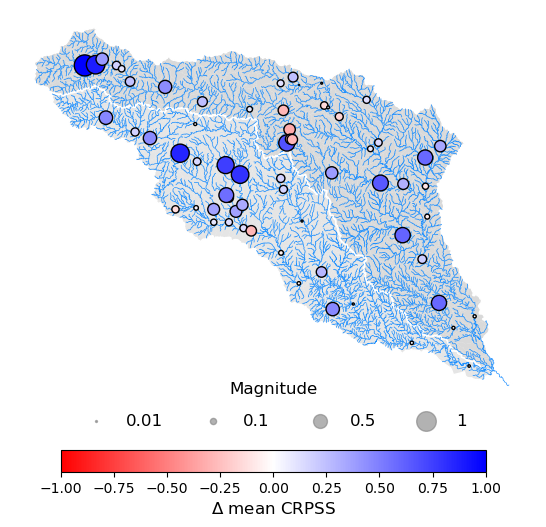

In [17]:
error_df = pd.DataFrame(list(diff_list.items()), columns=['stationid', 'error'])
merged_gage_shp_gua = gage_shp.merge(error_df, on='stationid')

error_df = pd.DataFrame(list(diff_list.items()), columns=['stationid', 'error'])
merged_gage_shp_san = gage_shp_san.merge(error_df, on='stationid')

norm = TwoSlopeNorm(vmin= - 1, vcenter=0, vmax= 1)

fig, ax = plt.subplots(figsize=(16, 6))
fig.patch.set_visible(False)

streams.to_crs(streams_san.crs).plot(ax=ax, color='dodgerblue',linewidth=0.5, zorder=3)
catchments.to_crs(streams_san.crs).plot(ax=ax, color='silver',alpha = 0.6, zorder=1)
# catchments.to_crs(streams.crs).boundary.plot(ax=ax, color='lightgrey', linewidth=0.5, zorder=2)
streams_san.to_crs(streams_san.crs).plot(ax=ax, color='dodgerblue',linewidth=0.5, zorder=3)
catchments_san.to_crs(streams_san.crs).plot(ax=ax, color='silver',alpha = 0.4, zorder=1)

boundary_san.to_crs(streams_san.crs).boundary.plot(ax=ax, color='white', linewidth=1, zorder=2)
boundary_gua.to_crs(streams_san.crs).boundary.plot(ax=ax, color='white', linewidth=1, zorder=2)

merged_gage_shp_gua.to_crs(streams_san.crs).plot(
    ax=ax, 
    column='error', 
    cmap='bwr_r', #'PiYG', 
    markersize=merged_gage_shp_gua['error'].abs() * 200,
    edgecolor='k', 
    legend=False, 
    # legend_kwds={'label': "mean CRPS skill score"},
    norm=norm,
    zorder=4
)

merged_gage_shp_san.to_crs(streams_san.crs).plot(
    ax=ax, 
    column='error', 
    cmap='bwr_r', #'PiYG', 
    markersize=merged_gage_shp_san['error'].abs() * 200,
    edgecolor='k', 
    legend=False, 
    # legend_kwds={'label': "mean CRPS skill score"},
    norm=norm,
    zorder=4
)

ax.axis('off')

size_labels = [0.01, 0.1, 0.5, 1] 
size_values = [label * 200 for label in size_labels]  

for size, label in zip(size_values, size_labels):
    ax.scatter([], [], c='gray', alpha=0.6, s=size, label=str(label))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Magnitude', loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(size_labels), fontsize=12, title_fontsize=12)

sm = plt.cm.ScalarMappable(cmap='bwr_r', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
cbar.set_label(r'$\Delta$ mean CRPSS', fontsize=12)
# cbar.set_label(r'mean CRPS skill score')

plt.show()

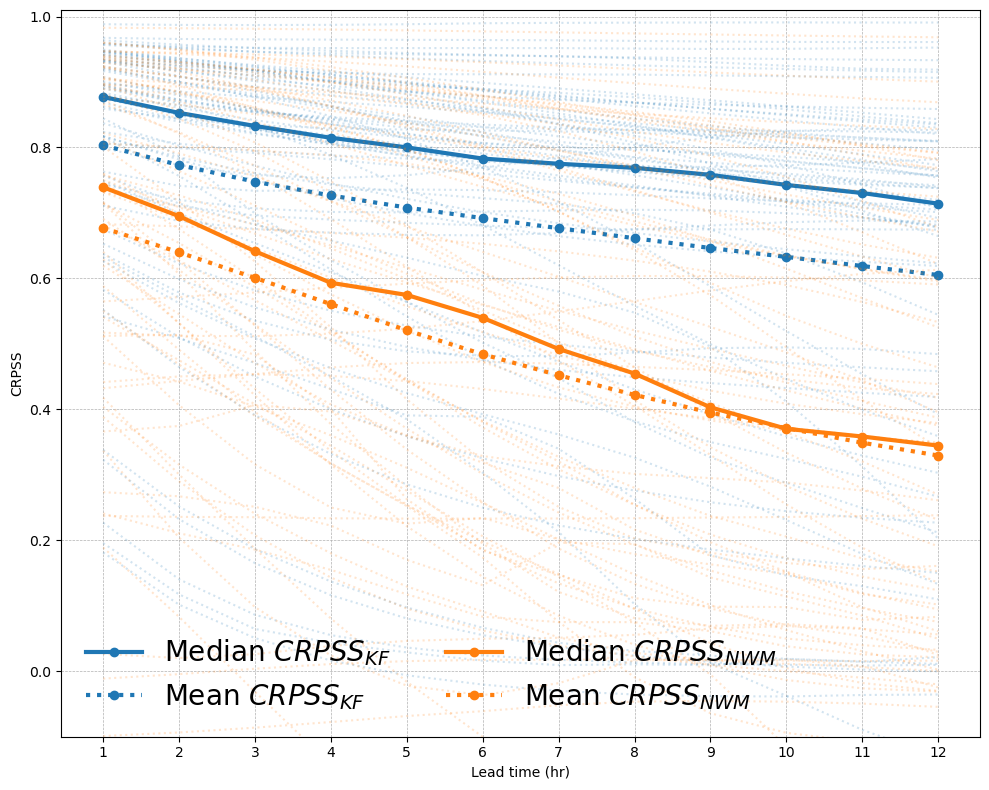

In [20]:
plt.figure(figsize=(10, 8))
skill_types = median_values.columns

color_map = {
    'DA Skill': plt.cm.tab10.colors[0], 
    'Raw Skill': plt.cm.tab10.colors[1]
}

for skill_type in skill_types:
    for subindex in melted_data['SubIndex'].unique():
        mask = (melted_data['Skill Type'] == skill_type) & (melted_data['SubIndex'] == subindex)
        individual_values = melted_data[mask]
        x = individual_values['Index'].to_numpy()
        y = individual_values['Skill Value'].to_numpy()
        plt.plot(x, y, linestyle=':', color=color_map[skill_type], alpha=0.2)

    # Simplified LaTeX labels
    label = 'CRPSS_{KF}' if skill_type == 'DA Skill' else 'CRPSS_{NWM}'
    latex_label = f'${label}$'
    
    x_med = median_values.index.to_numpy()
    y_med = median_values[skill_type].to_numpy()
    x_mean = mean_values.index.to_numpy()
    y_mean = mean_values[skill_type].to_numpy()
    
    plt.plot(x_med, y_med, linestyle='-', marker='o', color=color_map[skill_type], 
             label=f'Median {latex_label}', linewidth=3)
    plt.plot(x_mean, y_mean, linestyle=':', marker='o', color=color_map[skill_type], 
             label=f'Mean {latex_label}', linewidth=3)

plt.xticks(melted_data['Index'].unique())
plt.xlabel('Lead time (hr)')
plt.ylabel('CRPSS')

plt.legend(fontsize=20, loc='best', ncol=2, frameon=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-0.1, 1.01)

plt.tight_layout()
plt.show()

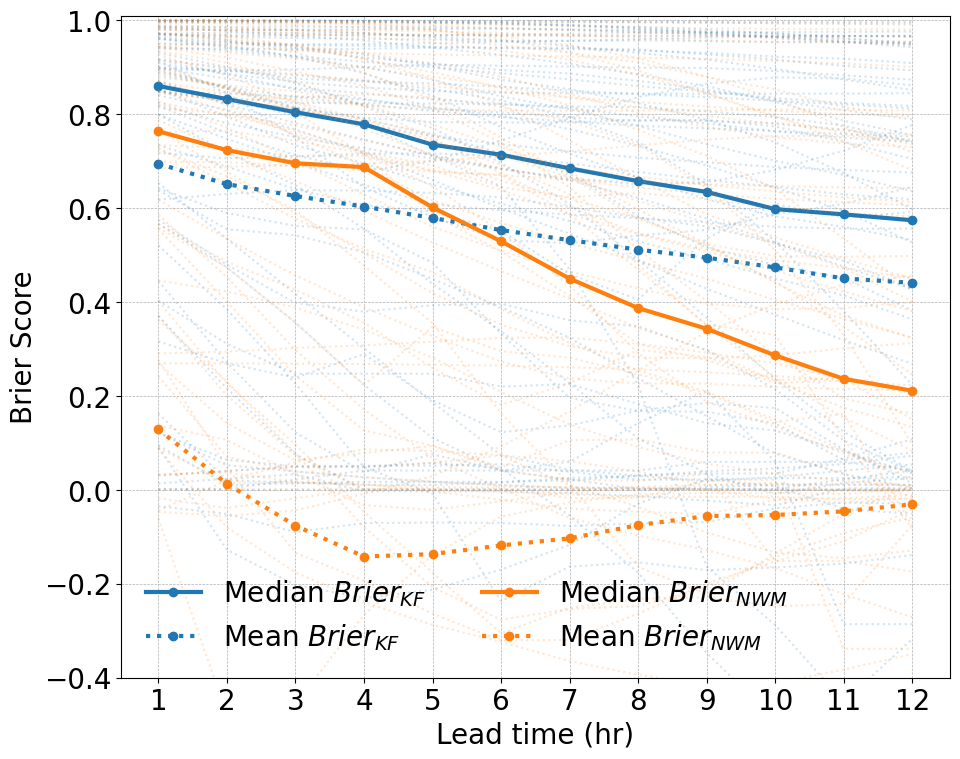

In [30]:
plt.figure(figsize=(10, 8))
skill_types = median_values_bs.columns

color_map = {
    'DA Skill': plt.cm.tab10.colors[0], 
    'Raw Skill': plt.cm.tab10.colors[1]
}

for skill_type in median_values_bs.columns:
    for subindex in melted_data_bs['SubIndex'].unique():
        mask = (melted_data_bs['Skill Type'] == skill_type) & (melted_data_bs['SubIndex'] == subindex)
        individual_values = melted_data_bs[mask]
        x = individual_values['Index'].to_numpy()
        y = individual_values['Skill Value'].to_numpy()
        plt.plot(x, y, linestyle=':', color=color_map[skill_type], alpha=0.2)

    # Simplified LaTeX labels
    label = 'Brier_{KF}' if skill_type == 'DA Skill' else 'Brier_{NWM}'
    latex_label = f'${label}$'
    
    x_med = median_values_bs.index.to_numpy()
    y_med = median_values_bs[skill_type].to_numpy()
    x_mean = mean_values_bs.index.to_numpy()
    y_mean = mean_values_bs[skill_type].to_numpy()
    
    plt.plot(x_med, y_med, linestyle='-', marker='o', color=color_map[skill_type], 
             label=f'Median {latex_label}', linewidth=3)
    plt.plot(x_mean, y_mean, linestyle=':', marker='o', color=color_map[skill_type], 
             label=f'Mean {latex_label}', linewidth=3)

plt.xticks(melted_data_bs['Index'].unique())
plt.xlabel('Lead time (hr)')
plt.ylabel('Brier Score')

plt.legend(fontsize=20, loc='best', ncol=2, frameon=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-0.4, 1.01)

plt.tight_layout()
plt.show()

### Individual site

In [23]:
overtop_flow = 152.97326866
site = '1623207' 

In [24]:
site_raw = {}
for date in date_range:
    site_raw[date] = raw[date][site].iloc[:19]
        
site_output = {}

for date in date_range:
    site_output[date] = all_outputs_open[date][site]
    
site_output_da = {}

for date in date_range:
    site_output_da[date] = {}
    for model in multi_models:
        site_output_da[date][model] = all_outputs_da[model][date][site]

obs_cms = usgs[site]

In [25]:
ensemble_weights_history, weighted_flows = calculate_ensemble_weights_and_flows(date_range, site_output_da, obs_cms, multi_models)

In [26]:
da_spreads = {}
da_spread = pd.concat((value for value in weighted_flows.values()), axis=1)
da_spread.columns = (pd.to_datetime(key, format='%Y%m%d%H').tz_localize('UTC') for key in site_output_da.keys())
da_spreads = da_spread

raw_spreads = {}
raw_spread = pd.concat((value for value in site_raw.values()), axis=1)
raw_spread.columns = (pd.to_datetime(key, format='%Y%m%d%H').tz_localize('UTC') for key in site_raw.keys())
raw_spreads = raw_spread

open_spreads = {}
open_spread = pd.concat((value for value in site_output.values()), axis=1)
open_spread.columns = (pd.to_datetime(key, format='%Y%m%d%H').tz_localize('UTC') for key in site_output.keys())
open_spreads = open_spread

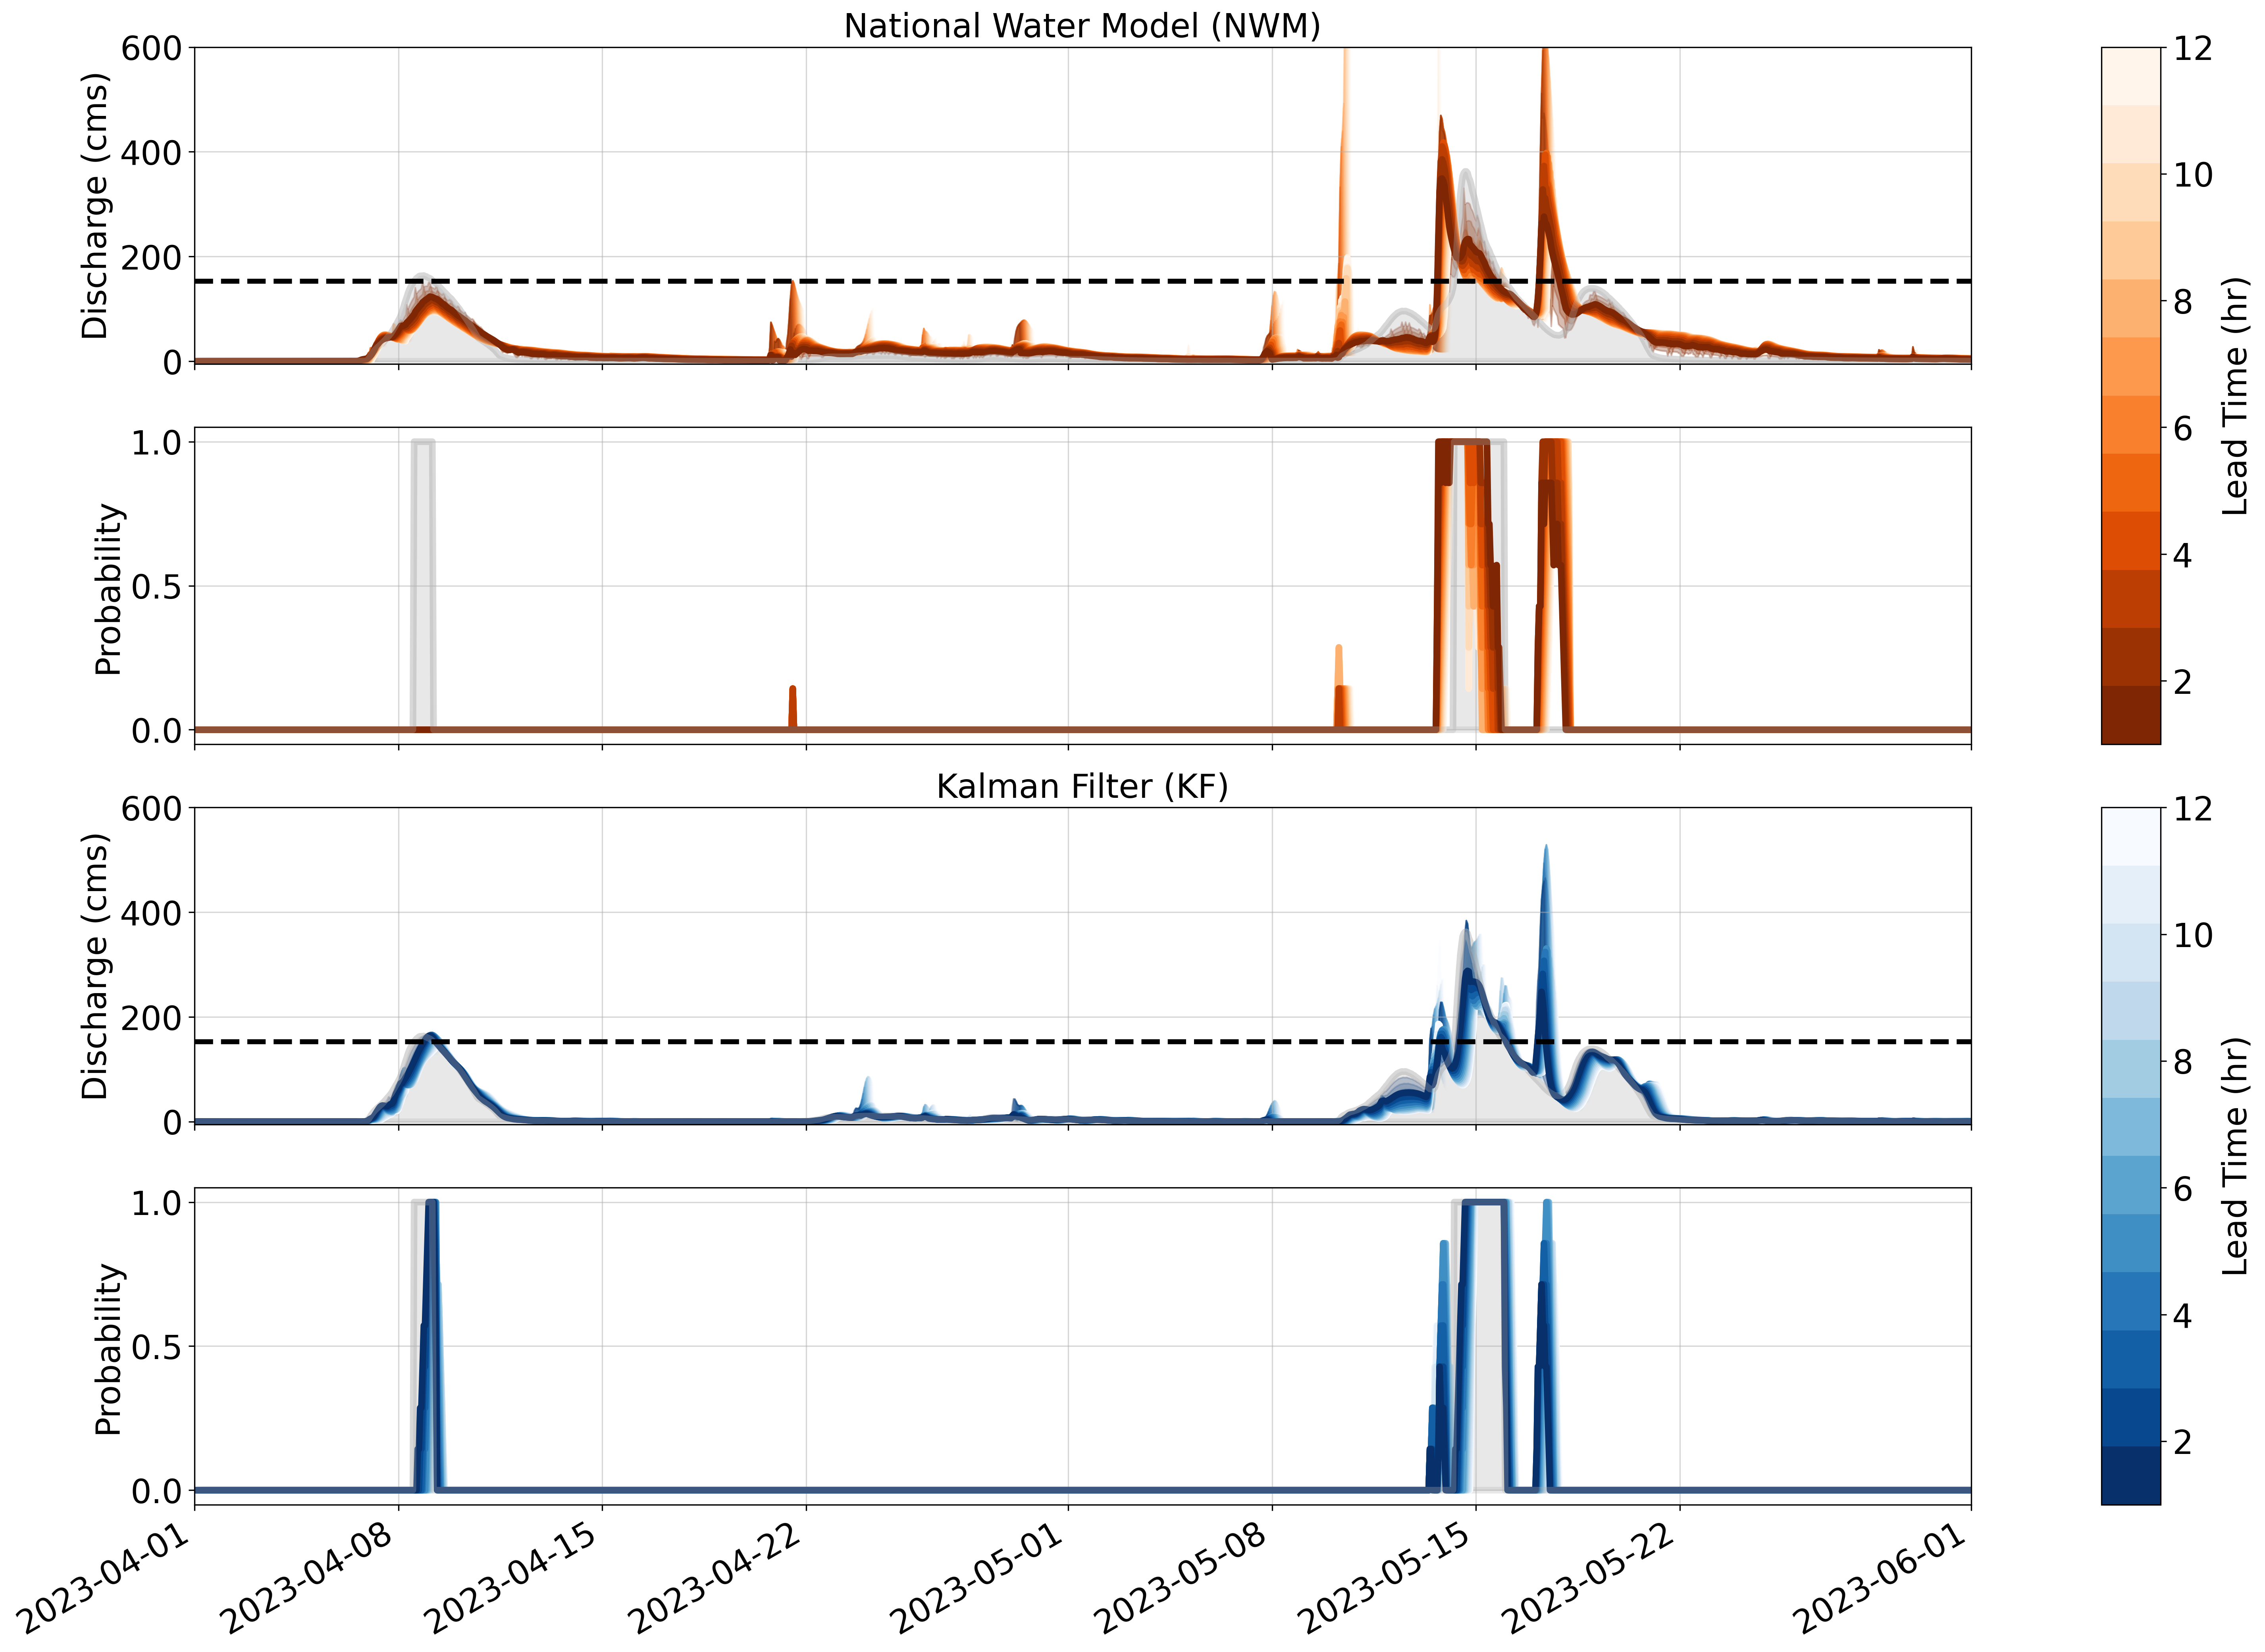

In [27]:
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 6
})

overflow_occured_plt = pd.Series(np.where(obs_cms > overtop_flow, 1., 0.), index=obs_cms.index).loc[raw_spreads.index]
lead_times = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] 

norm = mcolors.Normalize(vmin=min(lead_times), vmax=max(lead_times))

base_cmap_da = plt.get_cmap('Blues_r', len(lead_times))
base_cmap_nwm = plt.get_cmap('Oranges_r', len(lead_times))

fig = plt.figure(figsize=(24, 18), dpi=300)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 1], width_ratios=[1.5, 0.05, 0.1])
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[2, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[3, 0])

for i, lead_time in enumerate(lead_times):
    color_da = base_cmap_da(norm(lead_time))
    color_nwm = base_cmap_nwm(norm(lead_time)) 
    def mean_first_12_hours(row):
        valid_values = row.dropna()[-7 - lead_time: -lead_time]
        return valid_values.mean()

    def quantiles_first_12_hours(row, quantiles=[0.25, 0.5, 0.75]):
        valid_values = row.dropna()[-7 - lead_time: -lead_time]
        return valid_values.quantile(quantiles)
    
    def prob_first_12_hours(row):
        valid_values = row.dropna()[-7 - lead_time: -lead_time]
        prob = np.sum(np.where(valid_values > overtop_flow, 1., 0.))/len(valid_values)
        return prob

    timelagged_da_mean = da_spreads.apply(mean_first_12_hours, axis=1)
    timelagged_raw_mean = raw_spreads.apply(mean_first_12_hours, axis=1)

    timelagged_da_prob = da_spreads.apply(prob_first_12_hours, axis=1)
    timelagged_raw_prob = raw_spreads.apply(prob_first_12_hours, axis=1)

    quantiles = [0, 1]
    quantile_da = pd.DataFrame(da_spreads)
    for q in quantiles:
        quantile_da[f'quantile_{q}'] = da_spreads.apply(lambda row: quantiles_first_12_hours(row, [q])[q], axis=1)

    quantile_raw = pd.DataFrame(raw_spreads)
    for q in quantiles:
        quantile_raw[f'quantile_{q}'] = raw_spreads.apply(lambda row: quantiles_first_12_hours(row, [q])[q], axis=1)

    ax0.plot(timelagged_raw_mean, color=color_nwm, linewidth=4, label=f'Lead Time {lead_time} - Median DA Spread')
    ax0.fill_between(quantile_raw.index, quantile_raw['quantile_0'], quantile_raw['quantile_1'], color=color_nwm, alpha=0.3, label=f'Lead Time {lead_time} - 0-1 Quantile Range')

    ax1.plot(timelagged_da_mean, color=color_da, linewidth=4, label=f'Lead Time {lead_time} - Median DA Spread')
    ax1.fill_between(quantile_da.index, quantile_da['quantile_0'], quantile_da['quantile_1'], color=color_da, alpha=0.3, label=f'Lead Time {lead_time} - 0-1 Quantile Range')

    ax2.plot(timelagged_raw_prob, color=color_nwm, linewidth=4)
    ax3.plot(timelagged_da_prob, color=color_da, linewidth=4)

obs_cms.plot.area(ax=ax0, color='0.7', alpha=0.3, linewidth=4)
ax0.axhline(y=overtop_flow, linestyle='--', c='k', label='Overtopping discharge', linewidth=3)
ax0.set_ylabel('Discharge (cms)')
ax2.set_ylabel('Probability')
ax0.set_title('National Water Model (NWM)')

obs_cms.plot.area(ax=ax1, color='0.7', alpha=0.3, linewidth=4)
ax1.axhline(y=overtop_flow, linestyle='--', c='k', label='Overtopping discharge', linewidth=3)
ax1.set_ylabel('Discharge (cms)')
ax3.set_ylabel('Probability')
ax1.set_title('Kalman Filter (KF)')

overflow_occured_plt.plot.area(ax=ax2, color='0.7', alpha=0.3, linewidth=4)
overflow_occured_plt.plot.area(ax=ax3, color='0.7', alpha=0.3, linewidth=4)

ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax0.set_xlabel('')
ax1.set_xlabel('')

ax0.set_xlim(pd.to_datetime('20230401'), pd.to_datetime('20230601')) 
ax1.set_xlim(pd.to_datetime('20230401'), pd.to_datetime('20230601')) 
ax2.set_xlim(pd.to_datetime('20230401'), pd.to_datetime('20230601')) 
ax3.set_xlim(pd.to_datetime('20230401'), pd.to_datetime('20230601')) 
ax0.set_ylim([-5, 600])
ax1.set_ylim([-5, 600])
ax2.set_ylim([-0.05, 1.05])
ax3.set_ylim([-0.05, 1.05])

ax0.grid(alpha = 0.5)
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)
ax3.grid(alpha = 0.5)

sm_nwm = plt.cm.ScalarMappable(cmap=base_cmap_nwm, norm=norm)
sm_da = plt.cm.ScalarMappable(cmap=base_cmap_da, norm=norm)

sm_nwm.set_array([])
sm_da.set_array([])

cbar_ax0 = plt.subplot(gs[0:2, 1])
cbar_ax1 = plt.subplot(gs[2:4, 1])
fig.colorbar(sm_nwm, cax=cbar_ax0, label='Lead Time (hr)', pad=0.01)
fig.colorbar(sm_da, cax=cbar_ax1, label='Lead Time (hr)', pad=0.01)